In [1]:
import os
import lsdb
import numpy as np
import pandas as pd
import photod.locus as lt
import photod.bayes as bt
pd.set_option('display.max_columns', None)

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

In [2]:
from dask.distributed import Client

client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/home/seanmcgu/.pyenv/versions/photod/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38391 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38391/status,
Dashboard: http://127.0.0.1:38391/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40819,Workers: 96
Dashboard: http://127.0.0.1:38391/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:39267,Total threads: 1
Dashboard: http://127.0.0.1:36857/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:46059,


/home/seanmcgu/.pyenv/versions/photod/lib/python3.10/site-packages/hats/inspection/visualize_catalog.py:195: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


CPU times: user 6.85 s, sys: 3.29 s, total: 10.1 s
Wall time: 11.2 s


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

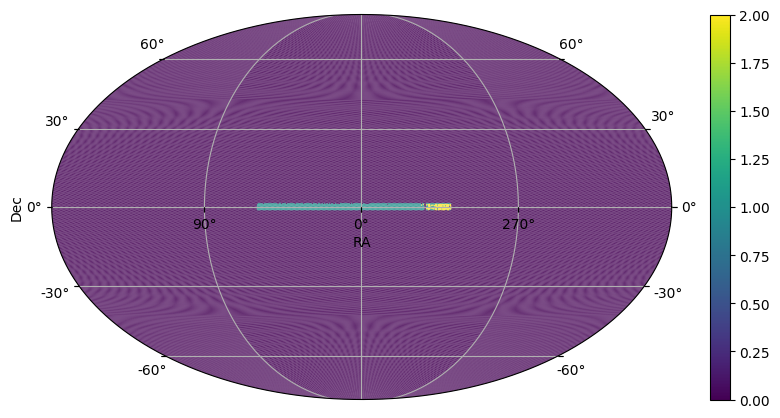

In [3]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - S82_fixed'}>)

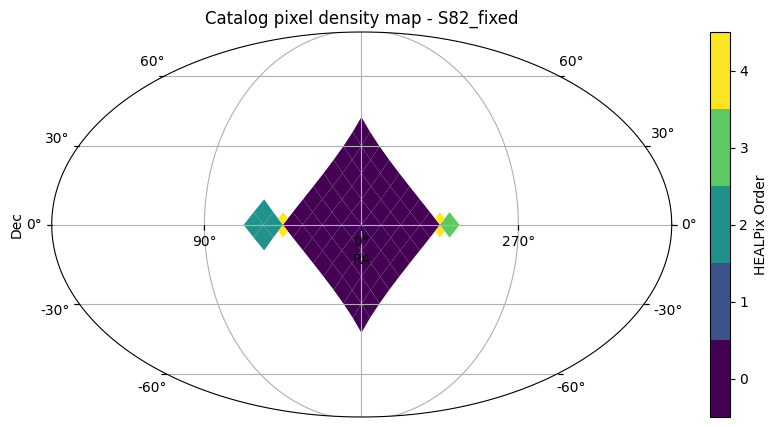

In [4]:
s82.plot_pixels()

Next, read the stellar locus parametrization.

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False, datafile="/home/seanmcgu/photoD_deploy/data/MSandRGBcolors_v1.3.txt") # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [6]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [7]:
fitColors = ('ug', 'gr', 'ri', 'iz')
pix_order = 5
pix_index = 0
priorsRootName = f'/mnt/beegfs/scratch/seanmcgu/photod/priors/TRILEGAL/S82/{pix_order}/{pix_index}'
outfile = 'results/S82_Bayes_estimates.txt'

Make 3D locus list with three ArGrid limits and resolutions.

In [8]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [9]:
df = s82.pixel_search([(pix_order,pix_index)]).compute()

In [10]:
iStart = 0
iEnd = len(df) # if<0: do all stars
# myStars = [0, 100, 1000, 10000] # for illustration, make plots for these stars
# myStars = [10, 233] # no plots
verb=False

In [11]:
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [ ]:
import cProfile

# with cProfile.Profile() as pr:
bt.makeBayesEstimates3D(
    df.reset_index(drop=True), 
    fitColors, 
    locusData, 
    locus3DList, 
    ArGridList, 
    priorsRootName, 
    outfile, 
    iStart, 
    iEnd, 
    verbose=verb
)

    # pr.dump_stats("/home/seanmcgu/bayes-3d.pstat")

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
